# Advanced Weather Model Training (API-Compatible)

**Tujuan:** Notebook ini merupakan versi peningkatan dari `weather_model_training_for_api.ipynb`. Tujuannya adalah untuk melatih model prediksi cuaca tunggal yang kompatibel dengan API, sambil mengintegrasikan praktik terbaik dan langkah-langkah evaluasi mendalam dari `training_guide.md`.

**Peningkatan Utama:**
1.  **Hyperparameter Tuning:** Menggunakan `GridSearchCV` untuk mencari parameter optimal bagi `RandomForestRegressor` pada tugas multi-output.
2.  **Evaluasi Mendalam:** Menyajikan tabel kinerja model untuk setiap parameter individual (Suhu, Kelembapan, dll.) seperti pada Tabel 5 di dokumen referensi.
3.  **Visualisasi Lengkap:** Menambahkan visualisasi perbandingan *Actual vs. Predicted* dan grafik dampak data inkremental sesuai panduan.

### 1. Persiapan Lingkungan dan Pemuatan Pustaka

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import os
import warnings

warnings.filterwarnings('ignore')
print("Libraries imported successfully.")

Libraries imported successfully.


### 2. Pengumpulan dan Pemuatan Data

In [2]:
# Load dataset
file_path = '../../data_collections/datasets/historical_data_hourly.csv'
df = pd.read_csv(file_path)

print(f"Total records loaded: {len(df)}")
display(df.head())

Total records loaded: 227280


,id,hour,day,month,year,temp,humidity,windspeed,sealevelpressure,weather_code,conditions
0,0,0,1,1,2000,21.8,98,4.0,1008.4,3,Overcast
1,1,1,1,1,2000,21.4,99,4.0,1007.9,3,Overcast
2,2,2,1,1,2000,21.4,98,3.2,1007.4,3,Overcast
3,3,3,1,1,2000,21.2,99,4.6,1007.0,3,Overcast
4,4,4,1,1,2000,21.0,99,3.6,1006.9,3,Overcast


### 3. Pra-pemrosesan Data

In [ ]:
# Handle missing values
df = df.dropna()

# Rename columns for consistency
if 'sealevelpressure' in df.columns:
    df = df.rename(columns={'sealevelpressure': 'pressure'})
if 'windspeed' in df.columns:
    df = df.rename(columns={'windspeed': 'wind_speed'})

# Create datetime features from timestamp or individual columns
if 'timestamp' not in df.columns or df['timestamp'].dtype != 'datetime64[ns]':
    df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour

print("\nData preprocessing complete.")
display(df[['timestamp', 'year', 'month', 'day', 'hour', 'temp', 'humidity', 'wind_speed', 'pressure', 'condition_encoded']].head())

Condition mapping:
{0: 'Clear', 1: 'Overcast', 2: 'Partially cloudy', 3: 'Rain', 4: 'Rain, Overcast'}

Data preprocessing complete.


,timestamp,year,month,day,hour,temp,humidity,wind_speed,pressure,condition_encoded
0,2000-01-01 00:00:00,2000,1,1,0,21.8,98,4.0,1008.4,1
1,2000-01-01 01:00:00,2000,1,1,1,21.4,99,4.0,1007.9,1
2,2000-01-01 02:00:00,2000,1,1,2,21.4,98,3.2,1007.4,1
3,2000-01-01 03:00:00,2000,1,1,3,21.2,99,4.6,1007.0,1
4,2000-01-01 04:00:00,2000,1,1,4,21.0,99,3.6,1006.9,1


### 4. Pelatihan Model Tingkat Lanjut dengan Hyperparameter Tuning

Berdasarkan `training_guide.md`, Random Forest adalah model terbaik. Di sini, kita akan melakukan tuning pada model tersebut menggunakan `GridSearchCV` untuk menemukan kombinasi parameter terbaik untuk tugas regresi multi-output.

In [ ]:
# Define Features (X) and Targets (y)
features = ['year', 'month', 'day', 'hour']
targets = ['temp', 'humidity', 'wind_speed', 'pressure']
X = df[features]
y = df[targets]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter Grid for Random Forest
param_grid = {
    'n_estimators': [50, 100],        # Number of trees
    'max_depth': [10, 20, None],      # Max depth of trees
    'min_samples_leaf': [1, 2, 4]       # Min samples in a leaf node
}

# Initialize the model and Grid Search
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='r2', verbose=2)

print("Starting Hyperparameter Tuning with GridSearchCV...")
grid_search.fit(X_train, y_train)

print("\nGridSearchCV Complete.")
print(f"Best Parameters Found: {grid_search.best_params_}")
print(f"Best R2 Score from CV: {grid_search.best_score_:.4f}")

# Get the best model from the grid search
best_rf_model = grid_search.best_estimator_

Starting Hyperparameter Tuning with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   1.9s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   1.8s
[CV] END ..max_depth=10, min_samples_leaf=1, n_estimators=50; total time=   1.9s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   3.6s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   3.3s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   3.4s
[CV] END ..max_depth=10, min_samples_leaf=2, n_estimators=50; total time=   1.9s
[CV] END ..max_depth=10, min_samples_leaf=2, n_estimators=50; total time=   2.0s
[CV] END ..max_depth=10, min_samples_leaf=2, n_estimators=50; total time=   2.0s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=100; total time=   3.4s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=100; total time=   3

### 5. Analisis Hasil dan Kinerja Individual Parameter (Sesuai Tabel 5)

In [5]:
y_pred = best_rf_model.predict(X_test)

results = []
print("--- Performance Evaluation of The Best Model ---")

for i, target_name in enumerate(targets):
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    
    # Clean up target name for display
    display_name = target_name.replace('_', ' ').capitalize()
    
    results.append({
        "Parameter": display_name,
        "MAE": mae,
        "RMSE": rmse,
        "R2 Score": r2
    })

results_df = pd.DataFrame(results)
display(results_df)

--- Performance Evaluation of The Best Model ---


,Parameter,MAE,RMSE,R2 Score
0,Temp,0.489189,0.691208,0.947573
1,Humidity,3.039974,4.445781,0.930678
2,Wind speed,1.590615,2.206284,0.683291
3,Pressure,0.482091,0.632451,0.884528
4,Condition encoded,0.660996,0.862318,0.385329


### 6. Penyimpanan Model Terbaik

In [6]:
artifacts = {
    'model': best_rf_model,
    'conditions_encoder': le
}

save_dir = '../models'
os.makedirs(save_dir, exist_ok=True)
filename = os.path.join(save_dir, 'rf_model_advanced.pkl')

with open(filename, 'wb') as f:
    pickle.dump(artifacts, f)

print(f"Tuned model and encoder saved successfully to: {filename}")

Tuned model and encoder saved successfully to: ../models\rf_model_advanced.pkl


### 7. Visualisasi Perbandingan Aktual vs. Prediksi (Sesuai Gambar 15-18)

Generating Actual vs. Predicted visualization for January 2020...


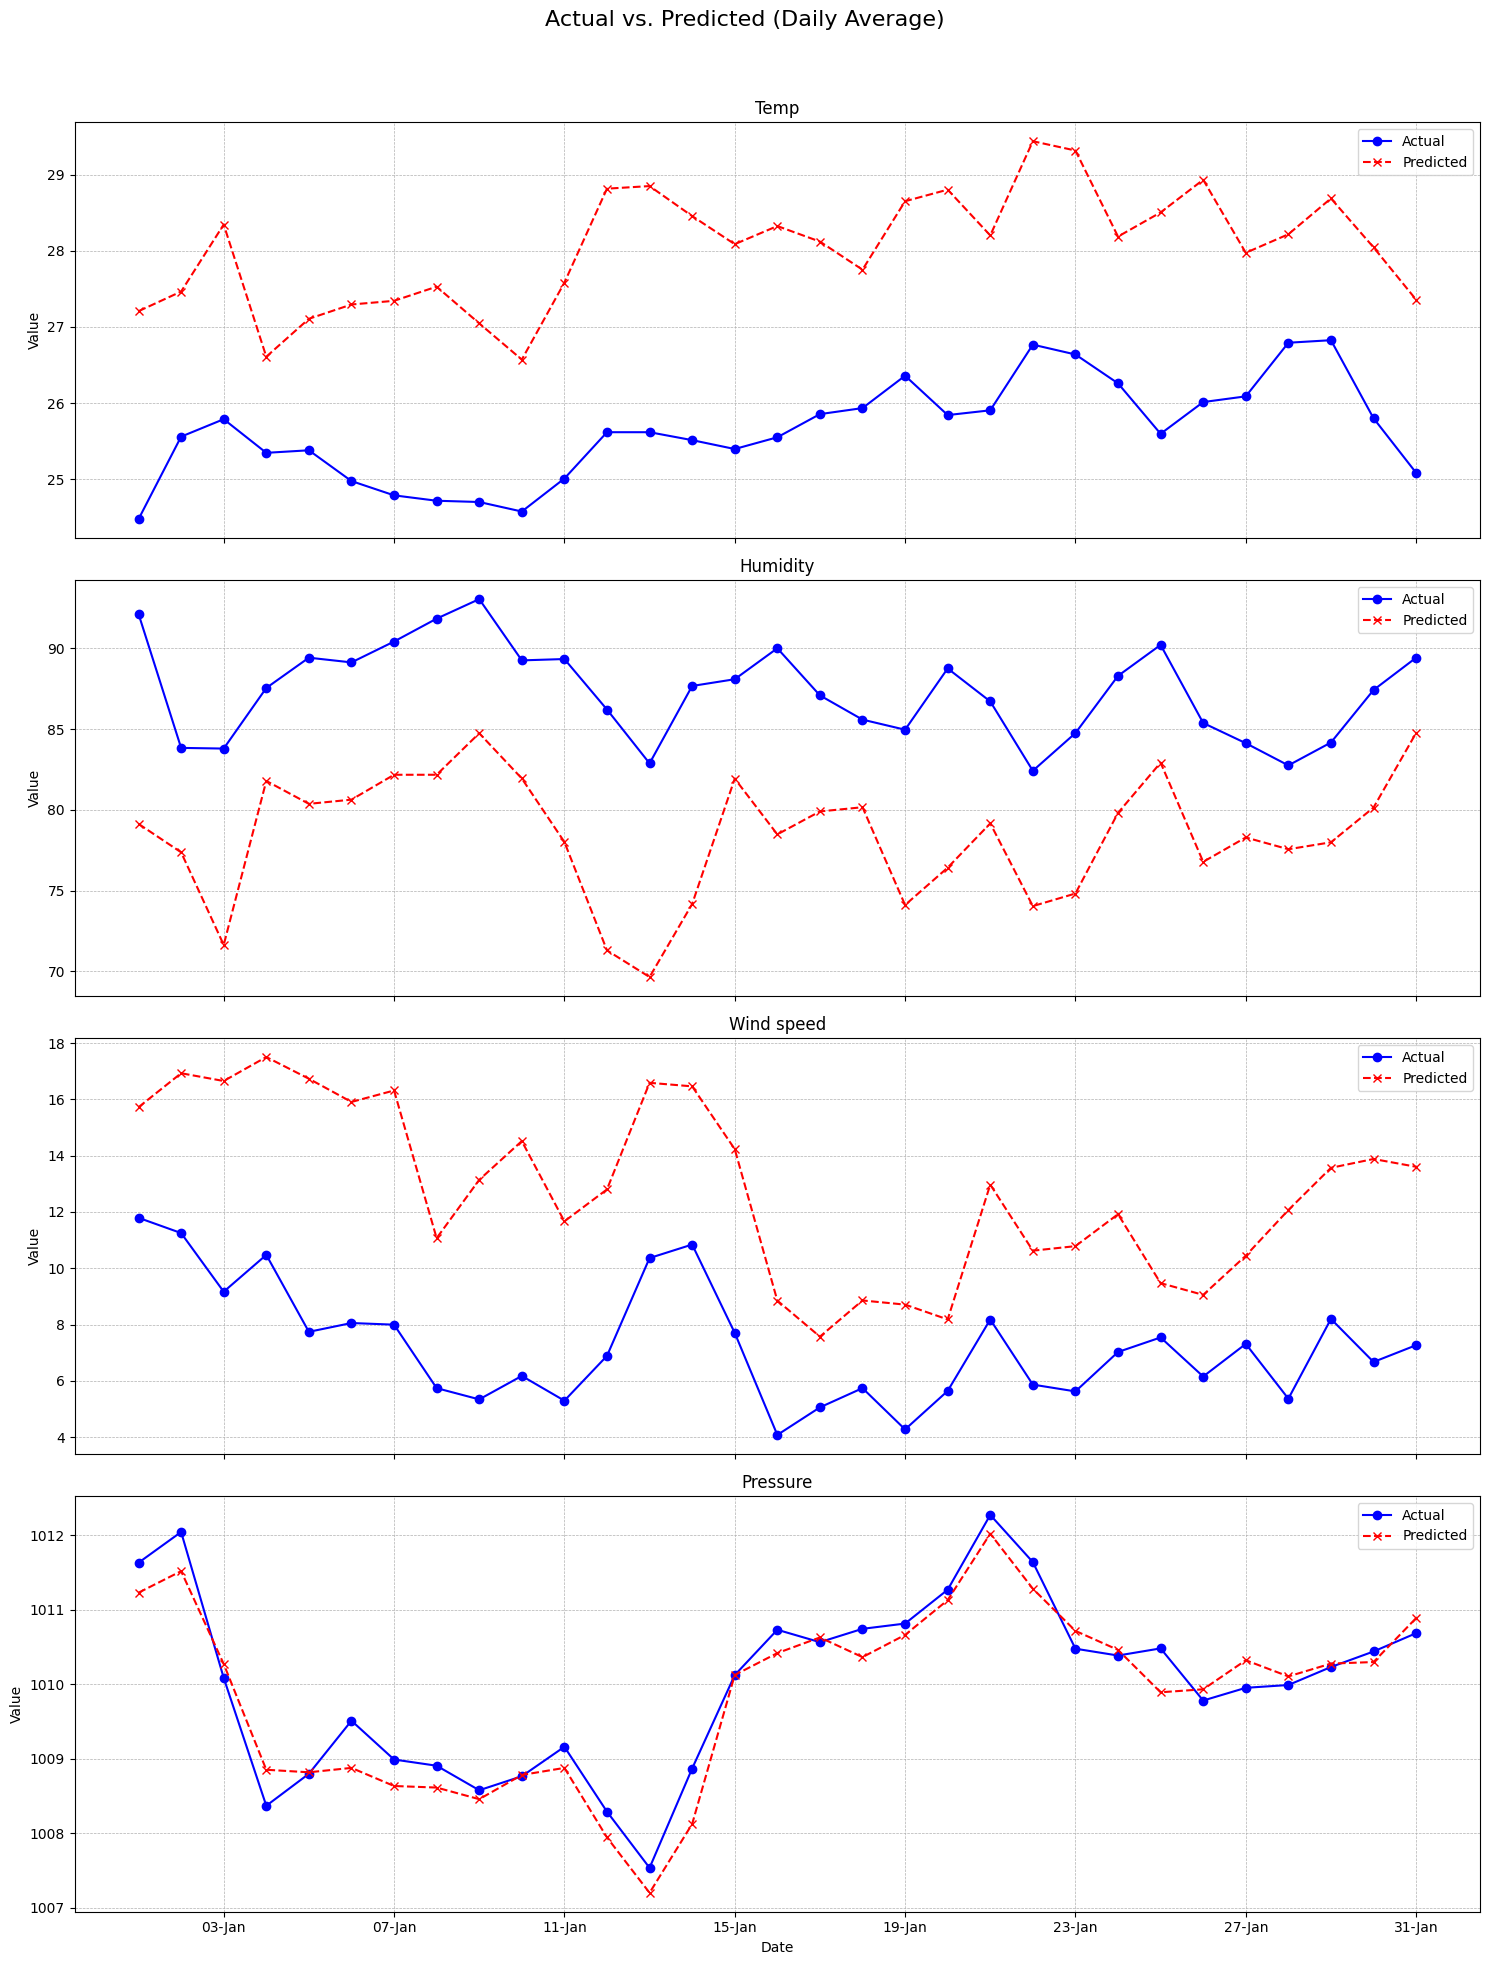

In [7]:
print("Generating Actual vs. Predicted visualization for January 2020...")

# Filter data for January 2020
jan_2020 = df[(df['year'] == 2020) & (df['month'] == 1)].copy()

if jan_2020.empty:
    print("No data for Jan 2020. Using the last available month in the dataset.")
    last_date = df['timestamp'].max()
    jan_2020 = df[(df['year'] == last_date.year) & (df['month'] == last_date.month)].copy()

# Aggregate daily for visualization
daily_actual = jan_2020.set_index('timestamp').resample('D').agg({
    'temp': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean',
    'pressure': 'mean'
}).dropna()

# Predict for the same period
X_daily_vis = pd.DataFrame({
    'year': daily_actual.index.year,
    'month': daily_actual.index.month,
    'day': daily_actual.index.day,
    'hour': 12 # Use noon as a representative hour for daily prediction
})

daily_pred_values = best_rf_model.predict(X_daily_vis)
daily_pred = pd.DataFrame(daily_pred_values, index=daily_actual.index, columns=targets)

# Plotting
vis_targets = ['temp', 'humidity', 'wind_speed', 'pressure']
fig, axes = plt.subplots(len(vis_targets), 1, figsize=(15, 20), sharex=True)
fig.suptitle('Actual vs. Predicted (Daily Average)', fontsize=16)

for i, target in enumerate(vis_targets):
    ax = axes[i]
    ax.plot(daily_actual.index, daily_actual[target], label='Actual', color='blue', marker='o', linestyle='-')
    ax.plot(daily_pred.index, daily_pred[target], label='Predicted', color='red', marker='x', linestyle='--')
    
    ax.set_title(target.replace('_', ' ').capitalize())
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

plt.xlabel('Date')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 8. Visualisasi Dampak Data Inkremental (Sesuai Gambar 21)

Generating visualization for incremental data impact...
Fraction: 0.1, R2 Score: 0.5910
Fraction: 0.2, R2 Score: 0.6299
Fraction: 0.3, R2 Score: 0.6600
Fraction: 0.4, R2 Score: 0.6838
Fraction: 0.5, R2 Score: 0.7038
Fraction: 0.6, R2 Score: 0.7220
Fraction: 0.7, R2 Score: 0.7337
Fraction: 0.8, R2 Score: 0.7453
Fraction: 0.9, R2 Score: 0.7575
Fraction: 1.0, R2 Score: 0.7655


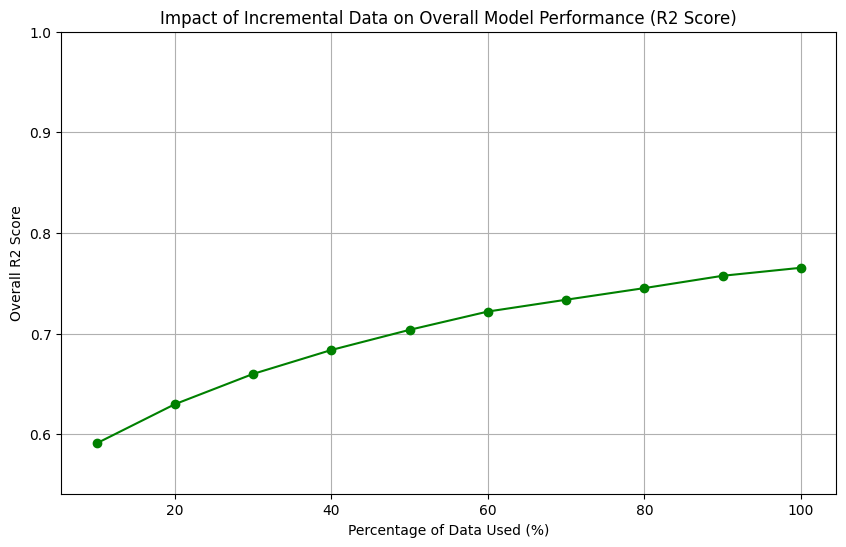

In [8]:
print("Generating visualization for incremental data impact...")

data_fractions = np.linspace(0.1, 1.0, 10)
r2_scores_incremental = []

# Use the best hyperparameters found earlier for a fair comparison
model_for_test = RandomForestRegressor(random_state=42, n_jobs=-1, **grid_search.best_params_)

for frac in data_fractions:
    subset_df = df.sample(frac=frac, random_state=42)
    
    X_sub = subset_df[features]
    y_sub = subset_df[targets]
    
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42)
    
    model_for_test.fit(X_train_sub, y_train_sub)
    y_pred_sub = model_for_test.predict(X_test_sub)
    
    # Evaluate overall R2 score
    r2 = r2_score(y_test_sub, y_pred_sub)
    r2_scores_incremental.append(r2)
    print(f"Fraction: {frac:.1f}, R2 Score: {r2:.4f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data_fractions * 100, r2_scores_incremental, marker='o', color='green', linestyle='-')
plt.title('Impact of Incremental Data on Overall Model Performance (R2 Score)')
plt.xlabel('Percentage of Data Used (%)')
plt.ylabel('Overall R2 Score')
plt.ylim(bottom=min(r2_scores_incremental) - 0.05, top=1.0)
plt.grid(True)
plt.show()